# define RBM class
here implement the RBM class, then we are going to instanciate this class for the training.


In RBM, the energy function is defined as
$$
E(x, h) = -a^\top x - b^\top h - x^\top W h \,.
$$

To make RBM as an energy-based model, the free energy function is computed as follows:

$$
\begin{align}
F(x) &= -\log \sum_h \exp (-E(x, h)) \\
     &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
\end{align}
$$


In [1]:
# Here we need to import the libraries that we are going to use
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class RBM(nn.Module):
    r"""Restricted Boltzmann Machine class.

    Args:
        n_vis (int): The number of visible units (e.g. 784 for MNIST).
        n_hid (int): The number of hidden units (typically less than n_vis).
        k (int, optional): The number of Gibbs sampling steps. Defaults to 1.
    """

    def __init__(self, n_vis, n_hid, k=1):
        super(RBM, self).__init__()
        self.n_vis = n_vis
        self.n_hid = n_hid
        self.k = k

        # Initialize parameters: small random weights and zero biases.
        self.W = nn.Parameter(torch.randn(n_vis, n_hid) * 0.01)
        self.a = nn.Parameter(torch.zeros(n_vis))  # visible bias
        self.b = nn.Parameter(torch.zeros(n_hid))  # hidden bias

    def visible_to_hidden(self, v):
        r"""
        Computes the hidden probabilities p(h|v) and samples h from a Bernoulli distribution.

        Args:
            v (Tensor): The visible variable of shape (batch_size, n_vis).

        Returns:
            Tensor: Binary sample of the hidden variable of shape (batch_size, n_hid).
        """
        # p(h=1|v) = sigmoid(v W + b)
        p = torch.sigmoid(torch.matmul(v, self.W) + self.b)
        return p.bernoulli()

    def hidden_to_visible(self, h):
        r"""
        Computes the visible probabilities p(v|h) and samples v from a Bernoulli distribution.

        Args:
            h (Tensor): The hidden variable of shape (batch_size, n_hid).

        Returns:
            Tensor: Binary sample of the visible variable of shape (batch_size, n_vis).
        """
        # p(v=1|h) = sigmoid(h W^T + a)
        p = torch.sigmoid(torch.matmul(h, self.W.t()) + self.a)
        return p.bernoulli()

    def free_energy(self, v):
        r"""
        Computes the free energy of the visible variables.

        Args:
            v (Tensor): The visible variable of shape (batch_size, n_vis).

        Returns:
            Tensor: A scalar tensor representing the mean free energy over the batch.
        """
        # Visible term: a^T v for each sample.
        v_term = torch.matmul(v, self.a)
        # Hidden term: sum_j log(1 + exp(v W + b)) for each sample.
        h_term = torch.sum(torch.log1p(torch.exp(torch.matmul(v, self.W) + self.b)), dim=1)
        # Free energy: F(v) = -a^T v - sum_j log(1 + exp(v W + b))
        free_energy = -v_term - h_term
        return torch.mean(free_energy)

    def forward(self, v):
        r"""
        Performs k steps of Gibbs sampling starting from the given visible sample.

        Args:
            v (Tensor): The visible variable of shape (batch_size, n_vis).

        Returns:
            tuple(Tensor, Tensor): The original visible variable and the generated sample after k Gibbs steps.
        """
        v_gibbs = v
        for _ in range(self.k):
            h = self.visible_to_hidden(v_gibbs)
            v_gibbs = self.hidden_to_visible(h)
        return v, v_gibbs


# Train

In [3]:
def train(model, train_loader, n_epochs=20, lr=0.01):
    r"""
    Args:
        model: The RBM model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.

    Returns:
        The trained model.
    """
    # Define the optimizer. Here we use Adam.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()

    for epoch in range(n_epochs):
        losses = []
        for _, (data, target) in enumerate(train_loader):
            # Flatten the data (e.g., MNIST images of size 28x28 become vectors of size 784)
            data = data.view(-1, 784)

            # Forward pass: get original and reconstructed visible units
            v, v_gibbs = model(data)

            # Compute loss as the free energy difference:
            # Loss = F(data) - F(reconstruction)
            loss = model.free_energy(data) - model.free_energy(v_gibbs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(losses)))

    return model


In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Hyperparameters
batch_size = 64            # Batch size for training
n_epochs = 20              # Number of training epochs
lr = 0.01                  # Learning rate
n_hid = 128                # Number of hidden units (you can adjust as needed)
n_vis = 784                # Number of visible units (28x28 for MNIST)

# Create the RBM model
model = RBM(n_vis=n_vis, n_hid=n_hid, k=1)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train the model using the provided train function
model = train(model, train_loader, n_epochs=n_epochs, lr=lr)

Epoch 0	 Loss=-9.2501
Epoch 1	 Loss=-2.6407
Epoch 2	 Loss=-0.1354
Epoch 3	 Loss=1.3678
Epoch 4	 Loss=1.9918
Epoch 5	 Loss=2.2405
Epoch 6	 Loss=2.4918
Epoch 7	 Loss=2.5515
Epoch 8	 Loss=2.6062
Epoch 9	 Loss=2.6656
Epoch 10	 Loss=2.7016
Epoch 11	 Loss=2.7362
Epoch 12	 Loss=2.7127
Epoch 13	 Loss=2.7821
Epoch 14	 Loss=2.8508
Epoch 15	 Loss=2.8551
Epoch 16	 Loss=2.8793
Epoch 17	 Loss=2.9273
Epoch 18	 Loss=2.9635
Epoch 19	 Loss=2.9159


In [20]:
# Save the trained model
torch.save(model.state_dict(), "rbm_model.pth")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# # Create a new instance of the RBM model with the same architecture
# model = RBM(n_vis=n_vis, n_hid=n_hid, k=1)

# # Load the saved state dictionary into the model
# model.load_state_dict(torch.load("rbm_model.pth"))
# model.eval()  # Set to evaluation mode

# print("Model loaded successfully!")

Model loaded successfully!


# Generate

In [21]:
# Get one batch of images from the train_loader
images, _ = next(iter(train_loader))

# Forward pass through the model.
# Flatten images from (batch_size, 1, 28, 28) to (batch_size, 784)
v, v_gibbs = model(images.view(-1, 784))

In [12]:
def show_and_save(img, file_name):
    import os
    r"""
    Args:
        img (Tensor): The image.
        file_name (Str): The destination.
    """
    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_name)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)

    np_img = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(np_img, cmap='gray')
    plt.imsave(f, np_img)


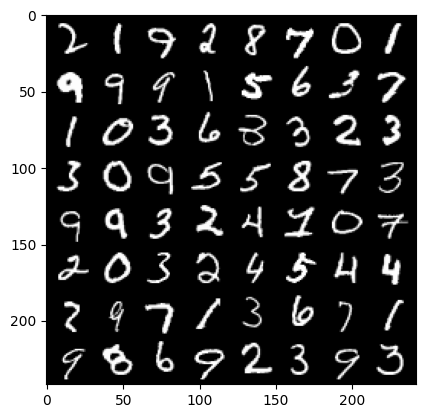

In [22]:
from torchvision.utils import make_grid
# Show the real images
show_and_save(make_grid(v.view(batch_size, 1, 28, 28).data), 'output/real')

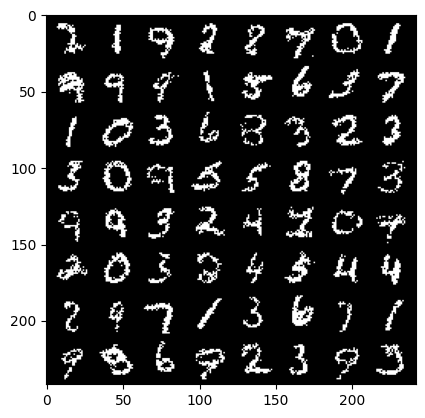

In [23]:
# Show the generated images
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'output/fake')
